In [1]:
# work_dir = '/Volumes/Xiguagua/kaggle/doodle/origin'
work_dir = '/home/huangcheng/kaggle/doodle-201811/data'

In [2]:
ls $work_dir/test

test_simplified.csv


In [3]:
cd {work_dir}

/home/huangcheng/kaggle/doodle-201811/data


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import ast


from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import concurrent.futures


# train_path = Path(work_dir)/'train_simplified/'
train_path = Path(work_dir)/'train/'




In [ ]:
# class_dict = {x.stem.replace(" ", "_"):i for i, x in enumerate(train_path.iterdir())}
# labels = {x.stem.replace(" ", "_") for i, x in enumerate(train_path.iterdir())}

# n_labels = len(labels)
# print("Number of labels: {}".format(n_labels))

In [5]:
def get_doodle_class(fname, recognized, pct):
    df = pd.read_csv(fname)
    if recognized==True: df = df[df['recognized']==True]
    df = df.sample(frac=pct, replace=False)
    return df
    
def get_doodle_dataset(path, pct = 0.05, random_state=22, recognized=False, max_workers=4):
    fnames = path.ls()
    flist = list()
    np.random.seed(random_state)
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        for c in tqdm(executor.map(partial(get_doodle_class, recognized=recognized, pct=pct),
                                           fnames), total=len(fnames)):
            flist.append(c)
    df = pd.concat(flist).reset_index(drop=True)
    df['word'] = df['word'].str.replace(' ', '_')
    return df

In [6]:
test = pd.read_csv(Path(work_dir)/'test/test_simplified.csv')

In [13]:
recognized=True
train = get_doodle_dataset(train_path, pct=0.015, random_state=11, max_workers=4, recognized=recognized)

100%|██████████| 340/340 [04:23<00:00,  1.17it/s]


In [14]:
train.to_csv('train_df_pct015_recognized')

In [7]:
# train = pd.read_csv('train_df_pct02_recognized')
train = pd.read_csv('train_df_pct015_recognized')
# train = pd.read_csv('train_df_pct015')

In [8]:
train['word'] = train['word'].astype('category')

In [27]:
# train, valid = train_test_split(train, test_size=0.10, random_state=36)

In [28]:
# print(train.shape, valid.shape, test.shape)

(614415, 6) (68269, 6) (112199, 3)


## Get Learner

In [9]:
BASE_SIZE=256


def strokes_to_np(raw_strokes, size=64, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                        (stroke[0][i+1], stroke[1][i+1]), color, lw)
    
    return cv2.resize(img, (size, size)) if size != BASE_SIZE else img
    

In [10]:
image_size=64

def subplots(rows:int, cols:int, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, title=None, **kwargs):
    "Like `plt.subplots` but with consistent axs shape, `kwargs` passed to `fig.suptitle` with `title`"
    figsize = ifnone(figsize, (imgsize*cols, imgsize*rows))
    fig, axs = plt.subplots(rows,cols,figsize=figsize)
    if (rows==1 and cols!=1) or (cols==1 and rows!=1): axs = [axs]
    if title is not None: fig.suptitle(title, **kwargs)
    return array(axs)


class DoodleList(ItemList):
    def get(self, i):
        im = strokes_to_np(ast.literal_eval(self.items[i]), size=image_size)
        im = Image(Tensor(im).unsqueeze(0).repeat(3,1,1))
        return im
    
    def reconstruct(self, t:Tensor): return Image(t.clamp(min=0,max=1))
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(math.sqrt(len(xs)))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [17]:
batch_size=768

data = (DoodleList
      .from_df(train, cols='drawing')
      .random_split_by_pct(0.1, seed=512)
      .label_from_df('word')
      .databunch(bs=batch_size))

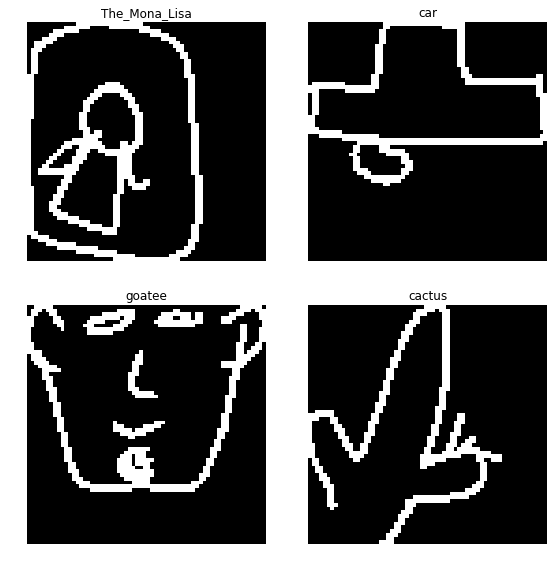

In [12]:
data.show_batch()

In [15]:
# db.normalize(imagenet_stats)

AttributeError: 'CategoryList' object has no attribute 'normalize'

In [31]:
# bs = 512
# sz = 64

# train_ds = DoodleDataset(train, size=sz)
# valid_ds = DoodleDataset(valid, size=sz)
# test_ds = DoodleDataset(test, size=sz, is_test=True)

In [32]:
# data = ImageDataBunch.create(train_ds, valid_ds, test_ds, bs=bs)
# data.normalize(imagenet_stats)

ImageDataBunch;
Train: <__main__.DoodleDataset object at 0x7ff60df63eb8>;
Valid: <__main__.DoodleDataset object at 0x7ff598afbf28>;
Test: <__main__.DoodleDataset object at 0x7ff60df63f28>

## Fit the modal

In [18]:
learn = create_cnn(data, 
                   models.resnet34, 
                   metrics=error_rate,
                   loss_func=F.cross_entropy)

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


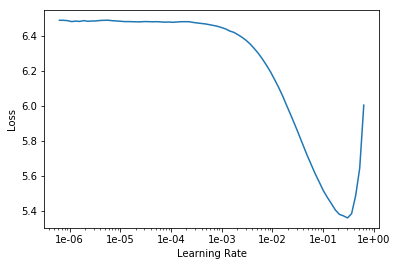

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(4, max_lr=5e-2)

epoch,train_loss,valid_loss,error_rate
1,1.964093,3.221241,0.683556
2,1.796293,1.891970,0.487505
3,1.426046,1.172813,0.328075
4,1.231289,1.043337,0.294545


In [22]:
learn.save('modal-freeze-epoch4')

In [23]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


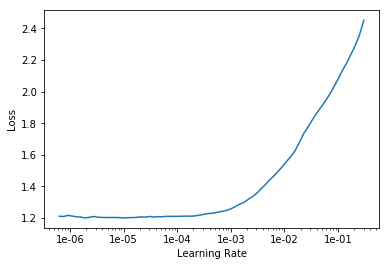

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,1.160053,1.015342,0.288598
2,1.051938,0.939484,0.268281
3,0.943573,0.856382,0.246997
4,0.884775,0.838264,0.242485


In [27]:
learn.save('modal-1')
# learn.load('modal-1')

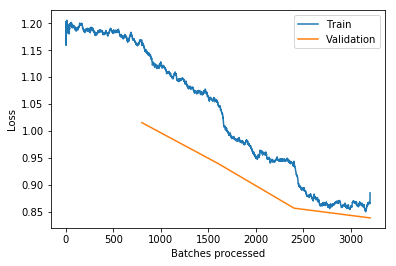

In [28]:
learn.recorder.plot_losses()

## Error analysis

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


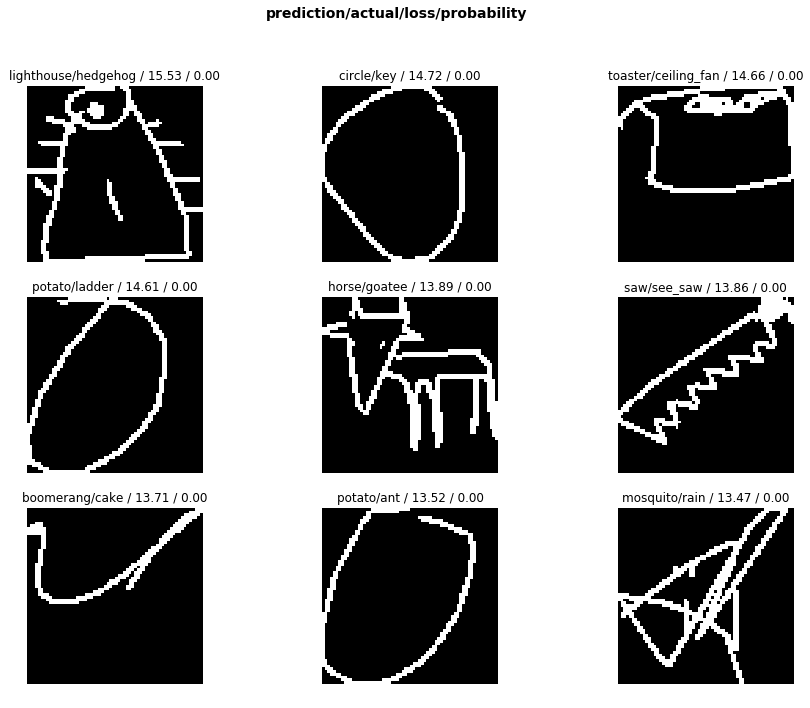

In [32]:
interp.plot_top_losses(9, figsize=(15,11))

In [34]:
_, idxs = interp.top_losses(k=9)
display(data.valid_ds.iloc[to_np(idxs)])

AttributeError: 'CategoryList' object has no attribute 'iloc'

## Archive

In [ ]:
def stroke2img(raw_strokes, size=64):
    img = Image.new()